# MedGAN Generator

This code generates molecules from the trained models saved. Each iteration generates 100 graphs and converts these graphs to molecules, filtering by quinoline scaffold, novelty and unique. The generator stops when there are 100 consecutive runs without generating additional molecules.

The code compares model 2 (subset ZINC15-II) and model 3 (subsets ZINC15-II and ZINC15-III).

In [ ]:
import os

current_directory = os.getcwd()
folders = [folder for folder in os.listdir(current_directory) if os.path.isdir(os.path.join(current_directory, folder))]

for folder in folders:
    print("Folder:", folder)

In [ ]:
import os
import re
import tensorflow as tf
from tensorflow.keras.models import load_model
from rdkit import Chem
import numpy as np
from scipy import stats
import pandas as pd
import numpy as np
import tensorflow as tf
from rdkit import RDLogger
from tqdm import tqdm
from tabulate import tabulate
from rdkit.Chem import rdMolHash

# Get the logger
lg = RDLogger.logger()

# Suppress the warnings
lg.setLevel(RDLogger.CRITICAL)

# Function for converting graphs into molecules
def graph_to_molecule_ii(graph):
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule
    try:
        # Attempt to sanitize the molecule
        flag = Chem.SanitizeMol(molecule, catchErrors=True)

        # Check the flag returned by the sanitization
        if flag != Chem.SanitizeFlags.SANITIZE_NONE:
            return None

    except AtomValenceException as e:
        # If an AtomValenceException error occurred, print the error and return None
        print(f"AtomValenceException during molecule sanitization: {e}")
        return None

    except Exception as e:
        # If any other unexpected error occurred, print the error and return None
        print(f"Unexpected error during molecule sanitization: {e}")
        return None

    # If sanitization was successful, return the molecule
    return molecule

def graph_to_molecule_iii(graph):
    adjacency, features = graph
    molecule = Chem.RWMol()

    # Filter out 'padding' atoms and bonds
    keep_idx = np.where(
        (np.sum(features[:, :ATOM_DIM], axis=1) != 0)  # not a 'padding' atom
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)  # connected to something
    )[0]
    
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    for i in range(len(keep_idx)):
        atom_type_idx = np.argmax(features[i, 0:7])
        atom_type = atom_mapping[atom_type_idx]
        atom = Chem.Atom(atom_type)

        # Handle charge
        charge_features = features[i, 7:9]  
        atom_charge = None
        for charge_value, charge_idx in charge_mapping.items():
            if charge_features[charge_idx - 7] == 1.0:  # Adjusting index for subset
                atom_charge = charge_value
                break

        if atom_charge is not None:
            atom.SetFormalCharge(atom_charge)

        # Handle chirality
        if features[i, 9] == 1:
            atom.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CCW)
        elif features[i, 10] == 1:
            atom.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CW)

        _ = molecule.AddAtom(atom)

    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule
    try:
        # Attempt to sanitize the molecule
        flag = Chem.SanitizeMol(molecule, catchErrors=True)
        
        # Check the flag returned by the sanitization
        if flag != Chem.SanitizeFlags.SANITIZE_NONE:
            return None  

    except AtomValenceException as e:
        print(f"AtomValenceException during molecule sanitization: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error during molecule sanitization: {e}")
        return None

    return molecule

def generate_molecule(generator, batch_size, version_end):
    z = tf.random.normal((batch_size, LATENT_DIM))
    graph = generator.predict(z, verbose=0)
    adjacency = tf.argmax(graph[0], axis=1)
    adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
    adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
    features = tf.argmax(graph[1], axis=2)
    features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
    molecules = []

    for i in range(batch_size):
        try:
            if version_end > 3:
                mol = graph_to_molecule_iii([adjacency[i].numpy(), features[i].numpy()])
                molecules.append(mol)
            else:
                mol = graph_to_molecule_ii([adjacency[i].numpy(), features[i].numpy()])
                molecules.append(mol)
        except Chem.rdchem.AtomValenceException:
            molecules.append(None)
    return molecules

def compute_validity(molecules):
    valid_molecules = [m for m in molecules if m is not None and m.GetNumAtoms() > 0]
    return len(valid_molecules) / len(molecules)

def is_fully_connected(mol):
    if mol is None:
        return False
    # GetMolFrags returns a list of tuples where each tuple contains the indices of the atoms in a connected fragment.
    fragments = Chem.GetMolFrags(mol)
    return len(fragments) == 1

def compute_connected_validity(molecules):
    valid_molecules = [m for m in molecules if m is not None and m.GetNumAtoms() > 0]
    
    if len(valid_molecules) == 0:
        return 0.0
    
    connected_molecules = [m for m in valid_molecules if is_fully_connected(m)]
    return len(connected_molecules) / len(valid_molecules)

def is_quinoline(mol):
    # Quinoline SMARTS pattern
    quinoline_smiles = 'n1cccc2ccccc12'
    quinoline_pattern = Chem.MolFromSmiles(quinoline_smiles)
    return mol.HasSubstructMatch(quinoline_pattern)

#def compute_quinoline_percentage(molecules):
#    quinoline_molecules = [m for m in molecules if m is not None and is_quinoline(m)]
#    return len(quinoline_molecules) / len(molecules)

def compute_quinoline_percentage(molecules):
    valid_molecules = [m for m in molecules if m is not None and m.GetNumAtoms() > 0 and is_fully_connected(m)]
    
    if len(valid_molecules) == 0:
        return 0.0
    
    quinoline_molecules = [m for m in valid_molecules if is_quinoline(m)]
    return len(quinoline_molecules) / len(valid_molecules)

# Function to convert a molecule to a canonical SMILES string
def molecule_to_smiles(mol):
    if mol is None:
        return None
    # Add Hydrogens to the molecule before generating SMILES
    mol_with_h = Chem.AddHs(mol)
    return Chem.MolToSmiles(mol_with_h, isomericSmiles=False, canonical=True)

# Function to compute the novelty
def compute_novelty(molecules, known_smiles):
    generated_smiles = set([molecule_to_smiles(m) for m in molecules if is_fully_connected(m)])
    if len(generated_smiles) == 0:
        return 0.0  # No fully connected molecules generated
    novel_smiles = generated_smiles - set(known_smiles)
    return len(novel_smiles) / len(generated_smiles)

# Function to compute the uniqueness
def compute_uniqueness(molecules):
    generated_smiles = [molecule_to_smiles(m) for m in molecules if is_fully_connected(m)]
    if len(generated_smiles) == 0:
        return 0.0  # No fully connected molecules generated
    unique_smiles = set(generated_smiles)
    return len(unique_smiles) / len(generated_smiles)

# Set the parameters
NUM_ATOMS = 50  # Maximum number of atoms
BOND_DIM = 4 + 1  # Number of bond types

folder_path = os.getcwd()

# Folder names for models
model_folders = [folder for folder in os.listdir(folder_path) if folder.startswith('model')]

# DataFrame to store the results
results = pd.DataFrame(columns=model_folders)

for selected_model in tqdm(model_folders, desc='Processing models'):

    # Extract the version number from the directory name
    version_pattern = re.compile(r'(\d+\.\d+)$')  # The regex stays the same
    version_match = version_pattern.search(selected_model)

    if not version_match:
        print(f"Cannot parse version number from {selected_model}")
        continue

    version_number = float(version_match.group(1))

    # Extract the decimal part and treat it as an integer
    version_decimal = int((version_number * 10) % 10)

    if version_decimal == 0:
        known_smiles = pd.read_csv('../data/quinolines_pubchem.csv')   # code to use optimization phase models
    elif version_decimal in [1, 2, 3]:
        #known_smiles = pd.read_csv('data/quinolines_zinc15.csv')   # code to use full zinc15 dataset in original code
        known_smiles = pd.read_csv('../data/non_duplicate_filtered_quinolines_zinc15_50atoms.csv')
    elif version_decimal in [4, 5]:
        known_smiles = pd.read_csv('../data/non_duplicate_filtered_quinolines_zinc15_50atoms.csv')
    else:
        print(f"Unknown version number {version_number} in model {selected_model}. Skipping.")
        continue

    version_end = float(version_match.group(1))

    if version_end < 2:
        atom_mapping = {"C": 0, "N": 1, "O": 2, "H": 3} 
        ATOM_DIM = 4 + 1  # Number of atom types
    elif version_end > 3:
        atom_mapping = {"C": 0, "N": 1, "O": 2, "H": 3, "F": 4, "S": 5, "Cl": 6} 
        ATOM_DIM = 11  # Number of atom types
        charge_mapping = {-1: 7, 1: 8}
    else:
        atom_mapping = {"C": 0, "N": 1, "O": 2, "H": 3, "F": 4, "S": 5, "Cl": 6} 
        ATOM_DIM = 7 + 1  # Number of atom types

    bond_mapping = {0: Chem.rdchem.BondType.SINGLE, 1: Chem.rdchem.BondType.DOUBLE, 2: Chem.rdchem.BondType.TRIPLE, 3: Chem.rdchem.BondType.AROMATIC, 4: None}

    # Set the latent dimension size
    version_number = selected_model.split("_")[-1]  # Extract the version number string
    version_number = version_number.replace('v', '')  # Remove 'v' if it exists
    version_start = float(version_number.split(".")[0])  # Convert the major version number to float

    if version_start < 3:
        LATENT_DIM = 64  # Size of the latent space
    else:
        LATENT_DIM = 256

    # Convert to bidirectional mapping for simplicity
    atom_mapping.update({v: k for k, v in atom_mapping.items()})

    # Load the models
    generator = load_model(os.path.join(folder_path, selected_model, "WGAN", "generator"))

    batch_size = 100

    validity_scores = []
    connected_validity_scores = []
    quinoline_percentages = []
    novelty_scores = []
    uniqueness_scores = []


    # run 10 times for testing code, originally the run was 1000
    for _ in tqdm(range(10), desc=f'Generating molecules for model {selected_model}'):
        generated_molecules = generate_molecule(generator, batch_size, version_end)
        validity = compute_validity(generated_molecules)
        connected_validity = compute_connected_validity(generated_molecules)
        quinoline_percentage = compute_quinoline_percentage(generated_molecules)
        validity_scores.append(validity)
        connected_validity_scores.append(connected_validity)
        quinoline_percentages.append(quinoline_percentage)
        novelty = compute_novelty(generated_molecules, known_smiles['smiles'].tolist())
        uniqueness = compute_uniqueness(generated_molecules)
        novelty_scores.append(novelty)
        uniqueness_scores.append(uniqueness)

    # Calculate mean and 95% confidence interval
    mean_validity = np.mean(validity_scores)
    ci = stats.t.interval(0.95, len(validity_scores)-1, loc=mean_validity, scale=stats.sem(validity_scores))
    results.loc['Validity', selected_model] = f'{mean_validity:.2f} ({ci[0]:.2f}:{ci[1]:.2f})'

    mean_connected_validity = np.mean(connected_validity_scores)
    ci_connected = stats.t.interval(0.95, len(connected_validity_scores)-1, loc=mean_connected_validity, scale=stats.sem(connected_validity_scores))
    results.loc['Connected Validity', selected_model] = f'{mean_connected_validity:.2f} ({ci_connected[0]:.2f}:{ci_connected[1]:.2f})'

    mean_quinoline_percentage = np.mean(quinoline_percentages)
    ci_quinoline = stats.t.interval(0.95, len(quinoline_percentages)-1, loc=mean_quinoline_percentage, scale=stats.sem(quinoline_percentages))
    results.loc['Quinoline Percentage', selected_model] = f'{mean_quinoline_percentage:.2f} ({ci_quinoline[0]:.2f}:{ci_quinoline[1]:.2f})'

    mean_novelty = np.mean(novelty_scores)
    ci_novelty = stats.t.interval(0.95, len(novelty_scores)-1, loc=mean_novelty, scale=stats.sem(novelty_scores))
    results.loc['Novelty', selected_model] = f'{mean_novelty:.2f} ({ci_novelty[0]:.2f}:{ci_novelty[1]:.2f})'

    mean_uniqueness = np.mean(uniqueness_scores)
    ci_uniqueness = stats.t.interval(0.95, len(uniqueness_scores)-1, loc=mean_uniqueness, scale=stats.sem(uniqueness_scores))
    results.loc['Uniqueness', selected_model] = f'{mean_uniqueness:.2f} ({ci_uniqueness[0]:.2f}:{ci_uniqueness[1]:.2f})'

# Print the table
print(tabulate(results, headers='keys', tablefmt='psql'))

In [ ]:
# Specify the path and filename for the CSV file
csv_file = "output_models_performance.csv"

# Save the table as a CSV file
results.to_csv(csv_file, index=True)

# Confirmation message
print(f"Table saved as CSV: {csv_file}")


In [ ]:
tf.config.list_physical_devices('GPU')

2023-09-28 21:53:16.212354: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 21:53:16.911647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ec2-user/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Processing models:   0%|          | 0/3 [00:00<?, ?it/s]2023-09-28 21:53:23.044410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA no

2023-09-28 21:53:26.526189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Total runs: 1, Unique molecules: 81


Processing models:  33%|███▎      | 1/3 [00:13<00:27, 13.88s/it]

Total runs: 2, Unique molecules: 117


Processing models:  67%|██████▋   | 2/3 [00:21<00:10, 10.22s/it]

Total runs: 1, Unique molecules: 111
Total runs: 1, Unique molecules: 23
Total runs: 2, Unique molecules: 30
Total runs: 3, Unique molecules: 35
Total runs: 4, Unique molecules: 38
Total runs: 5, Unique molecules: 39
Total runs: 6, Unique molecules: 39


Processing models: 100%|██████████| 3/3 [00:35<00:00, 11.89s/it]

Total runs: 7, Unique molecules: 39


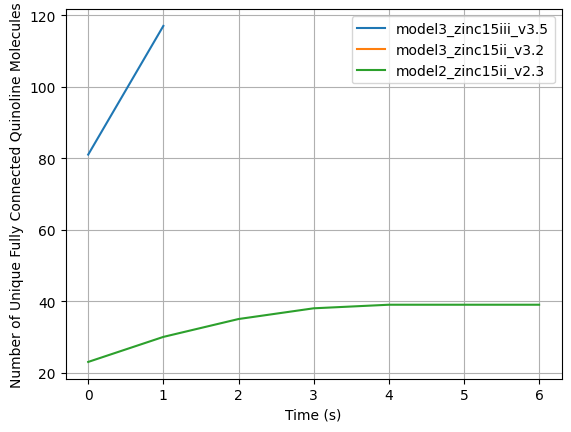

In [1]:
#output model capacity to generate and save molecules

import time
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import tensorflow as tf
from rdkit import Chem
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from rdkit.Chem import rdMolHash
from tensorflow.keras.models import load_model
from rdkit import RDLogger
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import rdchem

# Get the logger
lg = RDLogger.logger()

# Suppress the warnings
lg.setLevel(RDLogger.CRITICAL)

# Function for converting graphs into molecules
def graph_to_molecule_ii(graph):
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule
    try:
        # Attempt to sanitize the molecule
        flag = Chem.SanitizeMol(molecule, catchErrors=True)

        # Check the flag returned by the sanitization
        if flag != Chem.SanitizeFlags.SANITIZE_NONE:
            return None

    except AtomValenceException as e:
        # If an AtomValenceException error occurred, print the error and return None
        print(f"AtomValenceException during molecule sanitization: {e}")
        return None

    except Exception as e:
        # If any other unexpected error occurred, print the error and return None
        print(f"Unexpected error during molecule sanitization: {e}")
        return None

    # If sanitization was successful, return the molecule
    return molecule

def graph_to_molecule_iii(graph):
    adjacency, features = graph
    molecule = Chem.RWMol()

    # Filter out 'padding' atoms and bonds
    keep_idx = np.where(
        (np.sum(features[:, :ATOM_DIM], axis=1) != 0)  # not a 'padding' atom
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)  # connected to something
    )[0]
    
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    for i in range(len(keep_idx)):
        atom_type_idx = np.argmax(features[i, 0:7])
        atom_type = atom_mapping[atom_type_idx]
        atom = Chem.Atom(atom_type)

        # Handle charge
        charge_features = features[i, 7:9]  
        atom_charge = None
        for charge_value, charge_idx in charge_mapping.items():
            if charge_features[charge_idx - 7] == 1.0:  # Adjusting index for subset
                atom_charge = charge_value
                break

        if atom_charge is not None:
            atom.SetFormalCharge(atom_charge)

        # Handle chirality
        if features[i, 9] == 1:
            atom.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CCW)
        elif features[i, 10] == 1:
            atom.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CW)

        _ = molecule.AddAtom(atom)

    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule
    try:
        # Attempt to sanitize the molecule
        flag = Chem.SanitizeMol(molecule, catchErrors=True)
        
        # Check the flag returned by the sanitization
        if flag != Chem.SanitizeFlags.SANITIZE_NONE:
            return None  

    except AtomValenceException as e:
        print(f"AtomValenceException during molecule sanitization: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error during molecule sanitization: {e}")
        return None

    return molecule

def generate_molecule(generator, batch_size, version_end):
    z = tf.random.normal((batch_size, LATENT_DIM))
    graph = generator.predict(z, verbose=0)
    adjacency = tf.argmax(graph[0], axis=1)
    adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
    adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
    features = tf.argmax(graph[1], axis=2)
    features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
    molecules = []

    for i in range(batch_size):
        try:
            if version_end > 3:
                mol = graph_to_molecule_iii([adjacency[i].numpy(), features[i].numpy()])
                molecules.append(mol)
            else:
                mol = graph_to_molecule_ii([adjacency[i].numpy(), features[i].numpy()])
                molecules.append(mol)
        except Chem.rdchem.AtomValenceException:
            molecules.append(None)
    return molecules

def compute_validity(molecules):
    valid_molecules = [m for m in molecules if m is not None and m.GetNumAtoms() > 0]
    return len(valid_molecules) / len(molecules)

def is_fully_connected(mol):
    if mol is None:
        return False
    # GetMolFrags returns a list of tuples where each tuple contains the indices of the atoms in a connected fragment.
    fragments = Chem.GetMolFrags(mol)
    return len(fragments) == 1

def compute_connected_validity(molecules):
    valid_molecules = [m for m in molecules if m is not None and m.GetNumAtoms() > 0]
    
    if len(valid_molecules) == 0:
        return 0.0
    
    connected_molecules = [m for m in valid_molecules if is_fully_connected(m)]
    return len(connected_molecules) / len(valid_molecules)

def is_quinoline(mol):
    # Quinoline SMARTS pattern
    quinoline_smiles = 'n1cccc2ccccc12'
    quinoline_pattern = Chem.MolFromSmiles(quinoline_smiles)
    return mol.HasSubstructMatch(quinoline_pattern)

def compute_quinoline_percentage(molecules):
    valid_molecules = [m for m in molecules if m is not None and m.GetNumAtoms() > 0 and is_fully_connected(m)]
    
    if len(valid_molecules) == 0:
        return 0.0
    
    quinoline_molecules = [m for m in valid_molecules if is_quinoline(m)]
    return len(quinoline_molecules) / len(valid_molecules)

# Function to convert a molecule to a canonical SMILES string
def molecule_to_smiles(mol):
    if mol is None:
        return None
    # Add Hydrogens to the molecule before generating SMILES
    mol_with_h = Chem.AddHs(mol)
    return Chem.MolToSmiles(mol_with_h, isomericSmiles=False, canonical=True)

# Function to compute the novelty
def compute_novelty(molecules, known_smiles):
    generated_smiles = set([molecule_to_smiles(m) for m in molecules if is_fully_connected(m)])
    if len(generated_smiles) == 0:
        return 0.0  # No fully connected molecules generated
    novel_smiles = generated_smiles - set(known_smiles)
    return len(novel_smiles) / len(generated_smiles)

# Function to compute the uniqueness
def compute_uniqueness(molecules):
    generated_smiles = [molecule_to_smiles(m) for m in molecules if is_fully_connected(m)]
    if len(generated_smiles) == 0:
        return 0.0  # No fully connected molecules generated
    unique_smiles = set(generated_smiles)
    return len(unique_smiles) / len(generated_smiles)

def save_molecule_as_mol(molecule, file_path):
    writer = Chem.SDWriter(file_path)
    writer.write(molecule)
    writer.close()

def save_molecule_as_png(molecule, file_path):
    mol_no_H = Chem.RemoveHs(molecule)
    img = Draw.MolToImage(mol_no_H)
    img.save(file_path)

# Set the parameters
NUM_ATOMS = 50  # Maximum number of atoms
BOND_DIM = 4 + 1  # Number of bond types

folder_path = os.getcwd()

# Folder names for models
model_folders = [folder for folder in os.listdir(folder_path) if folder.startswith('model')]

# Dictionary to store results
capacity_data = defaultdict(list)

for selected_model in tqdm(model_folders, desc='Processing models'):
    # Extract the version number from the directory name
    version_pattern = re.compile(r'(\d+\.\d+)$')  # The regex stays the same
    version_match = version_pattern.search(selected_model)

    if not version_match:
        print(f"Cannot parse version number from {selected_model}")
        continue

    version_number = float(version_match.group(1))

    # Extract the decimal part and treat it as an integer
    version_decimal = int((version_number * 10) % 10)

    if version_decimal == 0:
        known_smiles = pd.read_csv('../data/quinolines_pubchem.csv')   # code to use optimization phase models
    elif version_decimal in [1, 2, 3]:
        #known_smiles = pd.read_csv('data/quinolines_zinc15.csv')   # code to use full zinc15 dataset in original code
        known_smiles = pd.read_csv('../data/non_duplicate_filtered_quinolines_zinc15_50atoms.csv')
    elif version_decimal in [4, 5]:
        known_smiles = pd.read_csv('../data/non_duplicate_filtered_quinolines_zinc15_50atoms.csv')
    else:
        print(f"Unknown version number {version_number} in model {selected_model}. Skipping.")
        continue

    version_end = float(version_match.group(1))

    if version_end < 2:
        atom_mapping = {"C": 0, "N": 1, "O": 2, "H": 3} 
        ATOM_DIM = 4 + 1  # Number of atom types
    elif version_end > 3:
        atom_mapping = {"C": 0, "N": 1, "O": 2, "H": 3, "F": 4, "S": 5, "Cl": 6} 
        ATOM_DIM = 11  # Number of atom types
        charge_mapping = {-1: 7, 1: 8}
    else:
        atom_mapping = {"C": 0, "N": 1, "O": 2, "H": 3, "F": 4, "S": 5, "Cl": 6} 
        ATOM_DIM = 7 + 1  # Number of atom types

    bond_mapping = {0: Chem.rdchem.BondType.SINGLE, 1: Chem.rdchem.BondType.DOUBLE, 2: Chem.rdchem.BondType.TRIPLE, 3: Chem.rdchem.BondType.AROMATIC, 4: None}

    # Set the latent dimension size
    version_number = selected_model.split("_")[-1]  # Extract the version number string
    version_number = version_number.replace('v', '')  # Remove 'v' if it exists
    version_start = float(version_number.split(".")[0])  # Convert the major version number to float

    if version_start < 3:
        LATENT_DIM = 64  # Size of the latent space
    else:
        LATENT_DIM = 256

    # Convert to bidirectional mapping for simplicity
    atom_mapping.update({v: k for k, v in atom_mapping.items()})

    # Load the models
    generator = load_model(os.path.join(folder_path, selected_model, "WGAN", "generator"))

    # Convert known_smiles DataFrame to a set for faster lookup
    known_smiles_set = set(known_smiles['smiles'].values)

    # Initialize a set to store the unique molecules
    unique_mols = set()

    # Initialize the timer
    start_time = time.time()
    last_new_molecule_time = start_time

    model_runs = 0
    N = 1  # Choose to print every 1 run

    os.makedirs(os.path.join(folder_path, selected_model, "generated_molecules"), exist_ok=True)

    # Initialize molecule index
    molecule_index = 0

    # Initialize a counter for consecutive runs without new molecules
    no_new_mol_counter = 0
    prev_unique_mol_count = 0

    while True:
        
        # Generate molecules
        generated_molecules = generate_molecule(generator, batch_size=1000, version_end=version_end)

        # Filter the molecules
        valid_molecules = [m for m in generated_molecules if m is not None and m.GetNumAtoms() > 0 and is_fully_connected(m) and is_quinoline(m)]
        
        # Get the unique molecules
        for molecule in valid_molecules:
            smiles = molecule_to_smiles(molecule)
            if smiles not in unique_mols and smiles not in known_smiles_set:
                unique_mols.add(smiles)
                last_new_molecule_time = time.time()

                # Check if the molecule is chemically feasible
                try:
                    Chem.SanitizeMol(molecule)
                except rdchem.MolSanitizeException:
                    print("Molecule is not chemically feasible.")
                    continue

                # Save the molecule as .mol and .png
                mol_file_path = os.path.join(folder_path, selected_model, "generated_molecules", f"molecule_{molecule_index}.mol")
                png_file_path = os.path.join(folder_path, selected_model, "generated_molecules", f"molecule_{molecule_index}.png")
                save_molecule_as_mol(molecule, mol_file_path)
                save_molecule_as_png(molecule, png_file_path)

                # Increase the molecule index by one
                molecule_index += 1

        # Update the counter for consecutive runs without new molecules
        if len(unique_mols) == prev_unique_mol_count:
            no_new_mol_counter += 1
        else:
            no_new_mol_counter = 0  # reset the counter
        prev_unique_mol_count = len(unique_mols)

        # Print the live counts every N molecules
        model_runs += 1
        if model_runs % N == 0:
            print(f"Total runs: {model_runs}, Unique molecules: {len(unique_mols)}")

        # Store the results every second
        elapsed_time = time.time() - start_time
        if int(elapsed_time) > len(capacity_data[selected_model]):
            capacity_data[selected_model].append(len(unique_mols))

        # Check if 100 consecutive runs have been done without new molecules or if 10 000 molecules have been generated for testing code
        if no_new_mol_counter >= 100 or len(unique_mols) >= 10_000:
            break

# Find the maximum length of lists in the dictionary
max_length = max(len(v) for v in capacity_data.values())

# Pad all lists in the dictionary to this maximum length
for k, v in capacity_data.items():
    if len(v) < max_length:
        capacity_data[k] += [None] * (max_length - len(v))

# Now convert to DataFrame
capacity_df = pd.DataFrame(capacity_data)
capacity_df.to_csv('output_capacity.csv', index=False)

# Plot the data
for model, data in capacity_data.items():
    plt.plot(range(len(data)), data, label=model)

plt.xlabel('Time (s)')
plt.ylabel('Number of Unique Fully Connected Quinoline Molecules')
plt.legend()
plt.grid(True)
plt.savefig('output_capacity.png')
plt.show()